# Install

In [ ]:
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth
!pip install pretty_midi

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth1 libqt5x11extras5 qsynth
Suggested packages:
  fluid-soundfont-gs timidity jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libfluidsynth1 libqt5x11extras5 qsynth
0 upgraded, 5 newly installed, 0 to remove and 7 not upgraded.
Need to get 120 MB of archives.
After this operation, 150 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libfluidsynth1 amd64 1.1.9-1 [137 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluidsynth amd64 1.1.9-1 [20.7 kB]
Get:4 http://archiv

In [ ]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple
import os
import keras
from keras import backend as K

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

# Read files

In [ ]:
# play notes
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform, rate=_SAMPLING_RATE)


def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})


def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)


def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))
  
  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))


def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

# Generate training dataset

In [ ]:
filenames = glob.glob(str('/content/*.mid*'))

In [ ]:
# read
all_notes = []
a = 0
for f in filenames:

  notes = midi_to_notes(f)
  all_notes.append(notes)


all_notes = pd.concat(all_notes)


n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

/usr/local/lib/python3.8/dist-packages/pretty_midi/pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Number of notes parsed: 482493


In [ ]:
raw_notes = midi_to_notes('/content/carnon_solo.mid')

In [ ]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name='Acoustic Grand Piano')

display_audio(example_pm)

generate dataset

In [ ]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

# Model and training

In [ ]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)
  
  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
seq_length = 50
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

In [ ]:
batch_size = 512
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

## VAE

In [ ]:
# encoder
latent_dim = 64
inter_dim = 32
timesteps, features = 1,1

def sampling(args):
    z_mean, z_log_sigma = args
    batch_size = tf.shape(z_mean)[0] # <================
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
    return z_mean + z_log_sigma * epsilon

def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
h = tf.keras.layers.LSTM(128)(inputs)



#z_layer
z_mean = keras.layers.Dense(latent_dim)(h)
z_log_sigma = keras.layers.Dense(latent_dim)(h)
z = keras.layers.Lambda(sampling)([z_mean, z_log_sigma])


# Reconstruction decoder
decoder1 = keras.layers.RepeatVector(timesteps)(z)
decoder1 = keras.layers.LSTM(inter_dim, activation='relu', return_sequences=True)(decoder1)


outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(decoder1),
  'step': tf.keras.layers.Dense(1, name='step')(decoder1),
  'duration': tf.keras.layers.Dense(1, name='duration')(decoder1),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.5,
        'step': 0.5,
        'duration':0.5,
    },
    optimizer=optimizer,
)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 50, 3)]      0           []                               
                                                                                                  
 lstm_1 (LSTM)                  (None, 128)          67584       ['input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 64)           8256        ['lstm_1[0][0]']                 
                                                                                                  
 dense_1 (Dense)                (None, 64)           8256        ['lstm_1[0][0]']                 
                                                                                            

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./checkpoints_VAE/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

Epoch 1/50
942/942 [==============================] - 61s 13ms/step - loss: 2.6235 - duration_loss: 0.2216 - pitch_loss: 3.4402 - step_loss: 1.5852
Epoch 2/50
942/942 [==============================] - 10s 10ms/step - loss: 2.4283 - duration_loss: 0.2204 - pitch_loss: 3.0536 - step_loss: 1.5826
Epoch 3/50
942/942 [==============================] - 10s 10ms/step - loss: 2.3423 - duration_loss: 0.2198 - pitch_loss: 2.8827 - step_loss: 1.5821
Epoch 4/50
942/942 [==============================] - 10s 10ms/step - loss: 2.2937 - duration_loss: 0.2196 - pitch_loss: 2.7858 - step_loss: 1.5818
Epoch 5/50
942/942 [==============================] - 10s 10ms/step - loss: 2.2551 - duration_loss: 0.2196 - pitch_loss: 2.7088 - step_loss: 1.5818
Epoch 6/50
942/942 [==============================] - 10s 10ms/step - loss: 2.2257 - duration_loss: 0.2197 - pitch_loss: 2.6501 - step_loss: 1.5816
Epoch 7/50
942/942 [==============================] - 10s 10ms/step - loss: 2.2019 - duration_loss: 0.2196 - pit

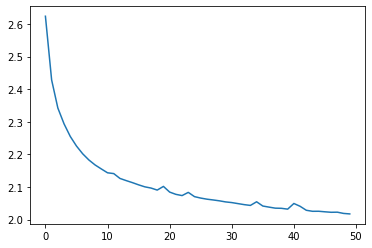

CPU times: user 10min 35s, sys: 41.3 s, total: 11min 16s
Wall time: 9min 40s


In [ ]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [ ]:
model.save_weights("ckpt")

In [ ]:
model.save('model_VAE', save_format='tf')

In [ ]:
!zip -r /content/model_VAE.zip /content/model_VAE

  adding: content/model_VAE/ (stored 0%)
  adding: content/model_VAE/keras_metadata.pb (deflated 90%)
  adding: content/model_VAE/variables/ (stored 0%)
  adding: content/model_VAE/variables/variables.data-00000-of-00001 (deflated 12%)
  adding: content/model_VAE/variables/variables.index (deflated 70%)
  adding: content/model_VAE/assets/ (stored 0%)
  adding: content/model_VAE/saved_model.pb (deflated 89%)


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Generate Music

In [ ]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']
 
  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits[0], num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [ ]:
temperature = 0.5
seq_length = 50
vocab_size = 128
key_order = ['pitch', 'step', 'duration']
num_predictions = min(120, len(raw_notes)-seq_length)

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

generated_notes = []
prev_start = raw_notes.iloc[seq_length]['start']

model = tf.keras.models.load_model('/content/drive/MyDrive/model_VAE', 
                                   custom_objects={'mse_with_positive_pressure':mse_with_positive_pressure,
                                                   'latent_dim' : 64})

for i in range(num_predictions):
  input_notes = (sample_notes[i:i+seq_length] / np.array([vocab_size, 1, 1]))
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  # if abs(pitch - raw_notes.iloc[i+seq_length]['pitch']) > 1:
  if np.random.rand(1)[0] > 0.5:
    pitch = raw_notes.iloc[i+seq_length]['pitch']
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

comb_notes = raw_notes.iloc[:seq_length].append(generated_notes)

1/1 [==============================] - 0s 16ms/step


Play generated midi file

In [ ]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    comb_notes, out_file=out_file, instrument_name='Acoustic Grand Piano')
display_audio(out_pm)